## Principal Component Analysis (PCA)

### Table of Contents
* [Theory](#Theory)
* [Applications of PCA](#applications)
    * [Data Visualization](#visualization)
    * [Speed-up Model Training](#modelTraining)
    * [Image Reconstruction](#image)

<a class="anchor" id="Theory"></a>
### Theory

<p>
    Principal Component Analysis (PCA) is a dimensionality reduction technique, based on the idea of matrix factorization. We're given data $x_1,x_2,...,x_n$ where $x \in \mathbb{R}^d$. This data is often high dimensional, but the "information" doesn't use the full $d$ dimensions. PCA maps each $x_i$ to a lower-dimensional coordinate system. It captures most of the information in the data in a few dimensions.
</p>

<p>
    Let's say $x \in \mathbb{R}^2$. How do we approximate this data using a unit-length vector $q$?
</p>

<p>
    $q$ is a unit-length vector, $q^Tq=1$. The vector $(q^Tx_i)q$ takes $q$ and stretches it to the projection of $x_i$ onto $q$. So what's a good $q$? How about minimizing the squared error?
</p>

$$q = arg \min_{q} \sum_{i=1}^{n} \begin{Vmatrix}x_i - qq^Tx_i\end{Vmatrix}^2$$ subject to $$q^Tq = 1$$

<p>
    Generalizing this, let's say $x$ resides in a 1000-dimensional space, and we need to find a vector $q \in \mathbb{R}^{1000}$ which has unit length, and which best approximates $x$. Let's define $X = [x_1,...,x_n]$. Upon expanding equation $(1)$, we get the following result
</p>

$$ q = arg \max_{q} q^T(XX^T)q$$ subject to $$q^Tq = 1$$

<p>
    This is the eigendecomposition problem. $q$ is the first eigenvector of $XX^T$ and $\lambda = q^T(XX^T)q$ is the first eigenvalue
</p>

<p>
    The general form of PCA considers $K$ eigenvectors.
</p>

$$ q = arg \min_{q} \sum_{i=1}^{n} \begin{Vmatrix} x_i - \sum_{k=1}^{K} (x_i^Tq_k)q_k \end{Vmatrix}^2$$ such that $$
q_k^Tq_{k^\prime} = \left\{
    \begin{array}\\
        1 & \mbox{if k = } k^\prime\\
        0 & \mbox{if k} \neq k^\prime
    \end{array}
\right.
$$

<p>
    The vectors in $Q = [q_1,...,q_K]$ give us a $K$ dimensional subspace with which to represent the data.
</p>

$$x_{proj} = \begin{pmatrix}
q_1^Tx \\
q_2^Tx \\
... \\
q_K^Tx
\end{pmatrix}$$

and $$ x \approx \sum_{k=1}^{K} (q_k^Tx)q_k \approx Qx_{proj}$$

Also see <a href="https://qr.ae/pr7e1g">this</a> quora answer for a nice explanation using Matrix calculus.

<a class="anchor" id="applications"></a>
### Applications of PCA

<a class="anchor" id="visualization"></a>
#### Data Visualization

Ref: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [1]:
import pandas as pd

# Iris dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=["sepal length","sepal width","petal length","petal width","target"])

<p>
    PCA is affected by scale (covariance matrix), and therefore it is important to standardize the dataset
</p>

In [3]:
from sklearn.preprocessing import StandardScaler

features = ["sepal length","sepal width","petal length","petal width"]

# separate out the features
x = df.loc[:,features].values

# separate out the target
y = df.loc[:,["target"]].values

# standardize the features
x = StandardScaler().fit_transform(x)

<p>
    PCA projection to 2D
</p>

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents, columns=["principal component 1","principal component 2"])

In [8]:
finalDf = pd.concat([principalDf, df[["target"]]], axis=1)

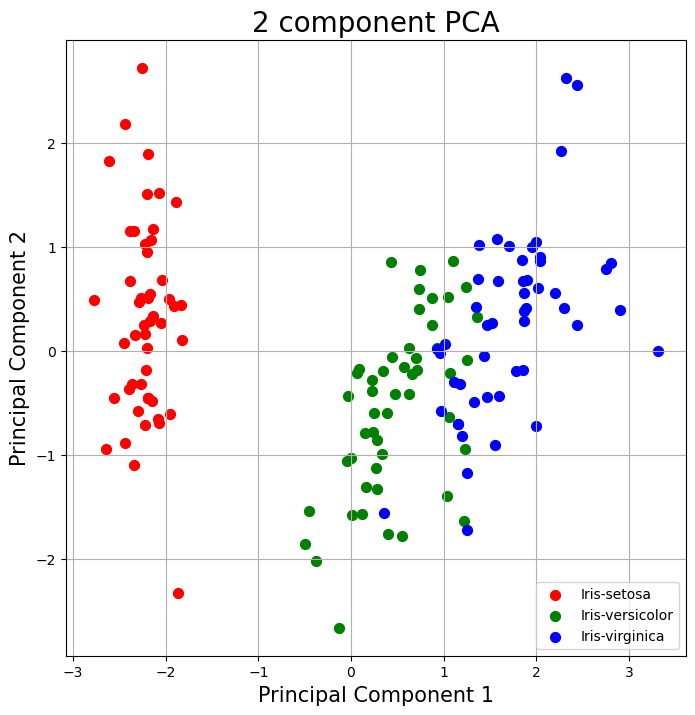

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Principal Component 1", fontsize=15)
ax.set_ylabel("Principal Component 2", fontsize=15)
ax.set_title("2 component PCA", fontsize=20)

targets = ["Iris-setosa","Iris-versicolor","Iris-virginica"]
colors = ["r","g","b"]
for target,color in zip(targets,colors):
    indicesToKeep = finalDf["target"] == target
    ax.scatter(finalDf.loc[indicesToKeep,"principal component 1"],
              finalDf.loc[indicesToKeep,"principal component 2"],
              c = color,
              s = 50)
ax.legend(targets)
ax.grid()

<p>
    Explained Variance tells us how much information (variance) can be attributed to each of the principal components. see <a href="https://stats.stackexchange.com/questions/22569/pca-and-proportion-of-variance-explained">here</a>
</p>

In [13]:
pca.explained_variance_ratio_

array([0.72770452, 0.23030523])

<a class="anchor" id="modelTraining"></a>
#### Speed-up model training

<p>
    This is one of the uncommon applications of PCA. We'll use the MNIST database of handwritten digits, which contains a training set of 60K and test set of 10K images. Each image is 784 dimensions.
</p>

In [15]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784")

<p>
    Split data into training and test dataset
</p>

In [16]:
from sklearn.model_selection import train_test_split

train_img, test_img, train_lbl, test_lbl = train_test_split(
    mnist.data, mnist.target, test_size=1/7.0, random_state=0
)

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit on training set only
scaler.fit(train_img)

# Apply transform to both training set and test set
train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)

In [18]:
from sklearn.decomposition import PCA

pca = PCA(0.95)

# Fit on training data only
pca.fit(train_img)

PCA(n_components=0.95)

In [20]:
pca.n_components_

327

In [21]:
# Apply the transform to both training and test images

train_img = pca.transform(train_img)
test_img = pca.transform(test_img)

In [24]:
# Run a logistic regression model

from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(solver="lbfgs")

In [25]:
logisticRegr.fit(train_img, train_lbl)

C:\Users\gajse\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [26]:
logisticRegr.predict(test_img[0].reshape(1,-1))

array(['0'], dtype=object)

In [28]:
# Accuracy of the model i.e. Correct Predictions / Total Predictions
logisticRegr.score(test_img, test_lbl)

0.9201

In [36]:
from sklearn.metrics import f1_score

# average = None returns F1 score for each class; average = micro returns a single F1 score based on total true positives
# etc; average = weighted returns a single F1 score with weights based on the number of samples for each class
f1_score(test_lbl,logisticRegr.predict(test_img),average=None)

array([0.96990973, 0.96183868, 0.89995167, 0.89804119, 0.92291881,
       0.88139535, 0.94508816, 0.92671395, 0.88911917, 0.89300412])

<a class="anchor" id="image"></a>
#### Image Reconstruction

Ref: https://analyticsindiamag.com/guide-to-image-reconstruction-using-principal-component-analysis/

In [7]:
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt

In [8]:
img = imread("C:/Users/gajse/Downloads/image-213.png")
print(img.shape)

(542, 725, 4)


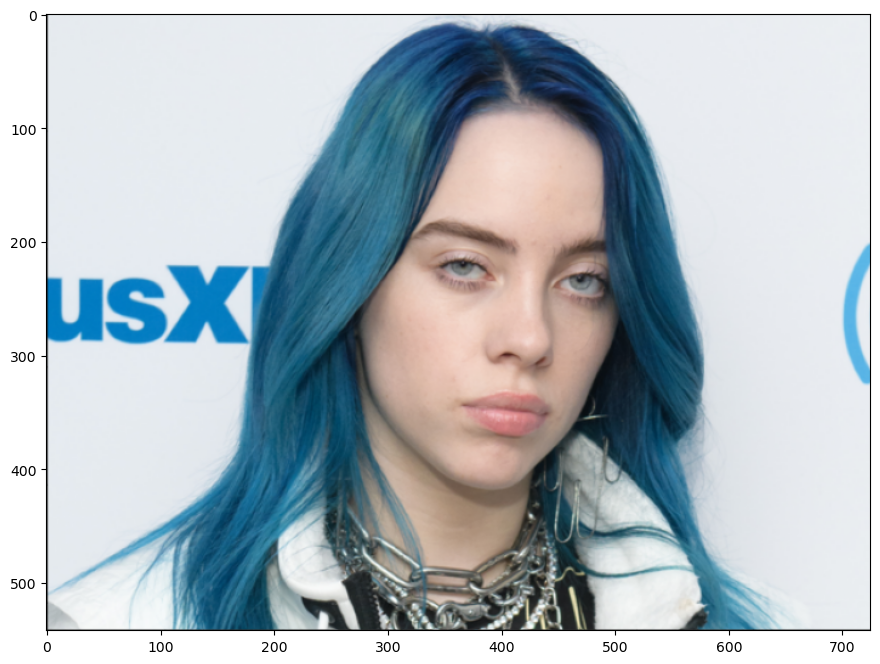

In [9]:
plt.figure(figsize=[12,8])
plt.imshow(img)

In [10]:
# grayscaling the image
img_gs = img.sum(axis=2)
print(img_gs.shape)

(542, 725)


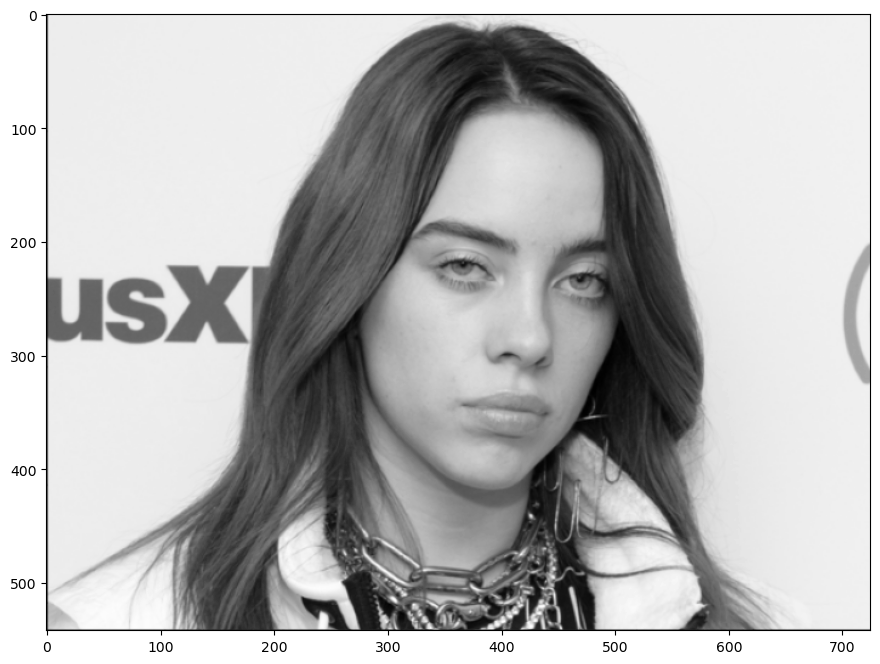

In [13]:
img_gs = img_gs/img_gs.max()

plt.figure(figsize=[12,8])
plt.imshow(img_gs, cmap=plt.cm.gray)

In [15]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(img_gs)

PCA()

In [16]:
cumu_var = np.cumsum(pca.explained_variance_ratio_)*100

In [19]:
# How many PCs explain 95% variance?
k = np.argmax(cumu_var > 95)

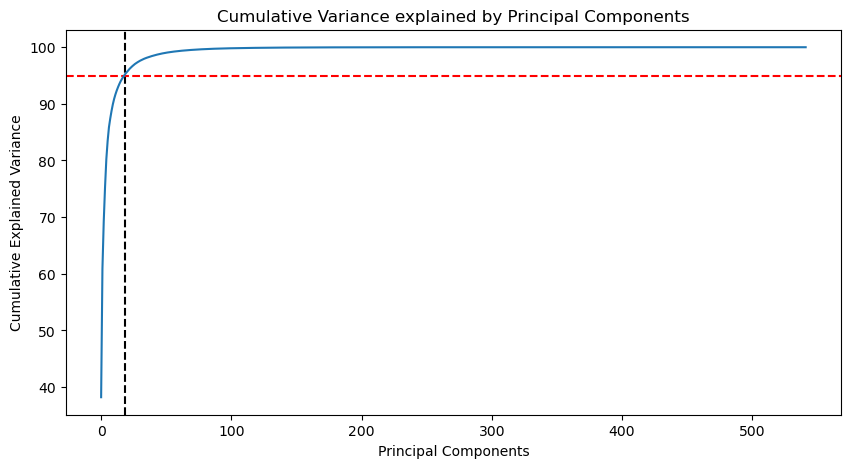

In [20]:
plt.figure(figsize=[10,5])
plt.title("Cumulative Variance explained by Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.xlabel("Principal Components")
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(cumu_var)

In [22]:
# Let's reconstruct the image using 18 components
pca = PCA(n_components=k)
img_recon = pca.inverse_transform(pca.fit_transform(img_gs))

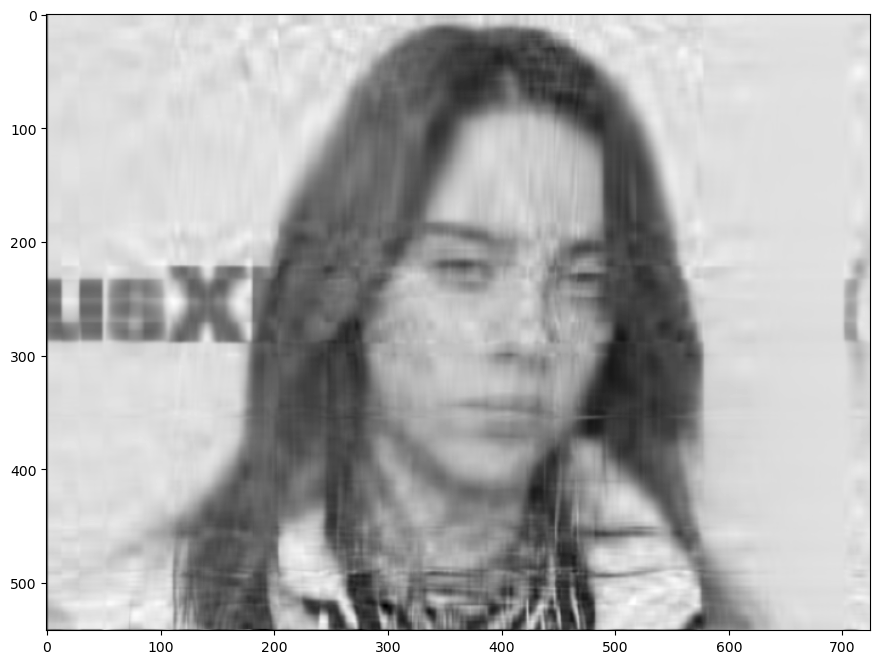

In [23]:
plt.figure(figsize=[12,8])
plt.imshow(img_recon, cmap=plt.cm.gray)